# Activity Tracker Buffer Model Generation for Arduino library : Arduino_TensorFlowLite

**Author**: Prashant Dandriyal

**Subject**: In support of proposal for GSoC 2020 to Arduino.



**Model**: Motion Sense Dataset from the link: https://github.com/mmalekzadeh/motion-sense/tree/master/data

In [1]:
#Get DeviceMotion data
!wget "https://github.com/mmalekzadeh/motion-sense/raw/master/data/A_DeviceMotion_data.zip"
!unzip "/content/A_DeviceMotion_data.zip"
!wget "https://raw.githubusercontent.com/mmalekzadeh/motion-sense/master/data/data_subjects_info.csv"

--2020-04-04 10:54:39--  https://github.com/mmalekzadeh/motion-sense/raw/master/data/A_DeviceMotion_data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mmalekzadeh/motion-sense/master/data/A_DeviceMotion_data.zip [following]
--2020-04-04 10:54:40--  https://raw.githubusercontent.com/mmalekzadeh/motion-sense/master/data/A_DeviceMotion_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73696396 (70M) [application/zip]
Saving to: ‘A_DeviceMotion_data.zip’

A_DeviceMotion_data 100%[===================>]  70.28M  70.5MB/s    in 1.0s    

2020-04-04 10:54:45 (70.5 MB/s) - ‘A_DeviceMotion_data.zi

In [0]:
import numpy as np
import pandas as pd

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """ data_subjects_info
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    np_dataset = dataset
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset, np_dataset


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}



In [19]:
import numpy as np
import pandas as pd
def get_ds_infos():
    ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
    dss = np.genfromtxt("data_subjects_info.csv",delimiter=',')
    dss = dss[1:]
    print("----> Data subjects information is imported.")
    return dss
##____________

def creat_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes):
    dataset_columns = num_features+num_act_labels+num_gen_labels
    ds_list = get_ds_infos()
    train_data = np.zeros((0,dataset_columns))
    test_data = np.zeros((0,dataset_columns))
    for i, sub_id in enumerate(ds_list[:,0]):
        for j, act in enumerate(label_codes):
            for trial in trial_codes[act]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                unlabel_data = raw_data.values
                label_data = np.zeros((len(unlabel_data), dataset_columns))
                label_data[:,:-(num_act_labels + num_gen_labels)] = unlabel_data
                label_data[:,label_codes[act]] = 1
                label_data[:,-(num_gen_labels)] = int(ds_list[i,4])
                ## We consider long trials as training dataset and short trials as test dataset
                if trial > 10:
                    test_data = np.append(test_data, label_data, axis = 0)
                else:    
                    train_data = np.append(train_data, label_data, axis = 0)
    return train_data , test_data
#________________________________


print("--> Start...")
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
num_features = 12 # attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
num_act_labels = 4 # dws, ups, wlk, jog
num_gen_labels = 1 # 0/1(female/male)
label_codes = {"dws":num_features, "ups":num_features+1, "wlk":num_features+2, "jog":num_features+3}
trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16]}    
## Calling 'creat_time_series()' to build time-series
print("--> Building Training and Test Datasets...")
train_ts, test_ts = creat_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes)
print("--> Shape of Training Time-Seires:", train_ts.shape)
print("--> Shape of Test Time-Series:", test_ts.shape)

--> Start...
--> Building Training and Test Datasets...
----> Data subjects information is imported.
--> Shape of Training Time-Seires: (621973, 17)
--> Shape of Test Time-Series: (145687, 17)


The dataset contains several cases like : "downStairs","upStairs", "walk", "jog", "stand" and "sit" but we only extract the last 4 for our analysis.

Also, out of the 4 parameters: attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z), we only need gravity, userAcceleration and rotationRate.



## Removing the redundant columns: 

In [0]:
dataset = dataset.drop(["id", "weight", "height", "age", "gender", "trial"], axis = 1)
dataset.head()

#Doing same for the numpy version
#i.e., remove last 6 columns from the data
np_dataset = np.delete(np_dataset, np.s_[-6:], axis = 1)

## Visualizing data

In [5]:
# Save previous df to csv
dataset.to_csv (r'data.csv', index = False, header=True)

# making data frame for different activities, from csv file 
data = pd.read_csv("data.csv", index_col ="act") 

# Filter rows by loc method 
# Selected activites: ['wlk', 'jog', 'std', 'sit'] -> 0, 1, 2, 3
df_wlk = data.loc[0] 
df_jog = data.loc[1] 
df_std = data.loc[2]
df_sit = data.loc[3]   

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


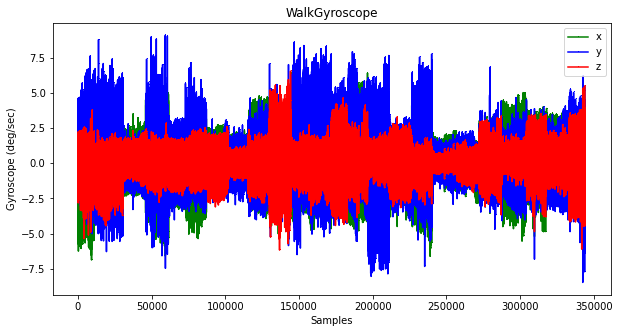

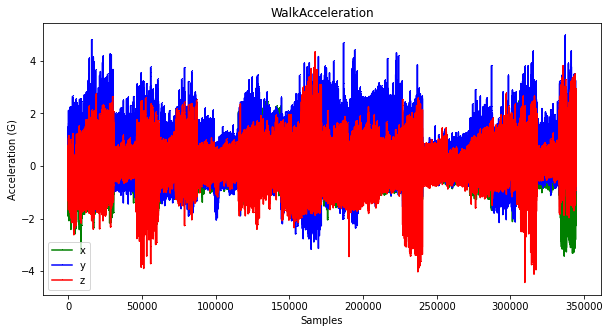

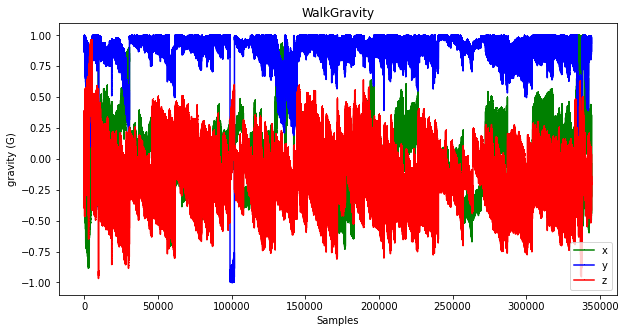

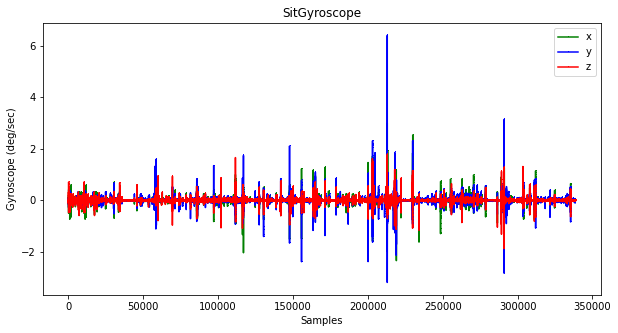

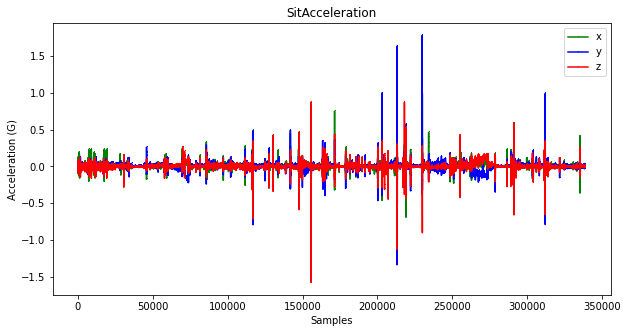

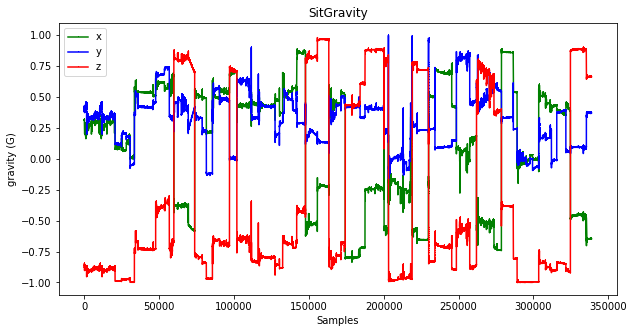

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def vis(df, name):
  index = range(1, len(df["gravity.x"]) + 1)

  plt.rcParams["figure.figsize"] = (10,5)

  plt.plot(index, df['rotationRate.x'], 'g.', label='x', linestyle='solid', marker=',')
  plt.plot(index, df['rotationRate.y'], 'b.', label='y', linestyle='solid', marker=',')
  plt.plot(index, df['rotationRate.z'], 'r.', label='z', linestyle='solid', marker=',')
  plt.title(name+"Gyroscope")
  plt.xlabel("Samples")
  plt.ylabel("Gyroscope (deg/sec)")
  plt.legend()
  plt.show()

  plt.plot(index, df['userAcceleration.x'], 'g.', label='x', linestyle='solid', marker=',')
  plt.plot(index, df['userAcceleration.y'], 'b.', label='y', linestyle='solid', marker=',')
  plt.plot(index, df['userAcceleration.z'], 'r.', label='z', linestyle='solid', marker=',')
  plt.title(name+"Acceleration")
  plt.xlabel("Samples")
  plt.ylabel("Acceleration (G)")
  plt.legend()
  plt.show()


  plt.plot(index, df['gravity.x'], 'g.', label='x', linestyle='solid', marker=',')
  plt.plot(index, df['gravity.y'], 'b.', label='y', linestyle='solid', marker=',')
  plt.plot(index, df['gravity.z'], 'r.', label='z', linestyle='solid', marker=',')
  plt.title(name+"Gravity")
  plt.xlabel("Samples")
  plt.ylabel("gravity (G)")
  plt.legend()
  plt.show()

#Plot for walk
vis(df_wlk, "Walk")
#Plot for sit and see the difference
vis(df_sit, "Sit")

## Standardize the values

In [0]:
# For gyroscope data
dataset['rotationRate.x'] = (dataset['rotationRate.x']+7.5)/15
dataset['rotationRate.y'] = (dataset['rotationRate.y']+7.5)/15
dataset['rotationRate.z'] = (dataset['rotationRate.z']+7.5)/15

np_dataset[:,3:6] = (np_dataset[:,3:6]+7.5)/15

# For accelerometer
dataset['userAcceleration.x'] = (dataset['userAcceleration.x']+4)/8
dataset['userAcceleration.y'] = (dataset['userAcceleration.y']+4)/8
dataset['userAcceleration.z'] = (dataset['userAcceleration.z']+4)/8

np_dataset[:,6:9] = (np_dataset[:,6:9]+4)/8

In [35]:
np_dataset.shape

(1123724, 10)

In [38]:

def time_series_to_section(dataset, num_act_labels, sliding_window_size, step_size_of_sliding_window):
    data = dataset[: , 0:-(num_act_labels)]         #(1123724, 9)
    act_labels = dataset[: , -num_act_labels: ]     #(1123724, 1)    

    ## We want the Rows of matrices show each Feature and the Columns show time points.
    data = data.T    #(9, 1123724))

    size_features = data.shape[0]     #9
    size_data = data.shape[1]         #1123724
    number_of_secs = round(((size_data - sliding_window_size)/step_size_of_sliding_window)) #112367 steps 
    # ... before all the data can be traversed 
            
    ##  Create a 3D matrix for Storing Snapshots  
    ## set of training inputs (x)
    secs_data = np.zeros((number_of_secs , size_features , sliding_window_size )) #(112367, 9, 50)
    ## set of training outputs (f(x))
    act_secs_labels = np.zeros((number_of_secs, 1)) #(112367, 1)
    
    k=0    
    for i in range(0 ,(size_data)-sliding_window_size  , step_size_of_sliding_window): # range(0, 1123674, 10)
        j = i // step_size_of_sliding_window #Using floor division () , j = 0, 1 , ...112365, 112366, 112367. (last elem = 112367 because = round(1123674/10) )
        if(j>=number_of_secs):      # 
            break
        ### Note: 
        if(not (act_labels[i] == act_labels[i+sliding_window_size-1]).all()): 
            continue    
        
        secs_data[k] = data[0:size_features, i:i+sliding_window_size]   # data[9, 0:50]
        act_secs_labels[k] = act_labels[i].astype(int)
        k = k+1
    secs_data = secs_data[0:k]
    act_secs_labels = act_secs_labels[0:k]
    
    return secs_data, act_secs_labels

## This Variable Defines the Size of Sliding Window
## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor) 
sliding_window_size = 50 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
## Here We Choose Step Size for Building Diffrent Snapshots from Time-Series Data
## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
step_size_of_sliding_window = 10 
num_act_labels = 1 # All 4 classes [walk, sit, jog, stand (but in order)] in single column 
num_features = 9

print("--> Sectioning Training and Test datasets: shape of each section will be: (",num_features,"x",sliding_window_size,")")
train_data, act_train_labels = time_series_to_section(np_dataset.copy(),
                                                      num_act_labels,
                                                      sliding_window_size,
                                                      step_size_of_sliding_window)
                                                                                                                                                                                             
print("--> Shape of Training Sections:", train_data.shape)

--> Sectioning Training and Test datasets: shape of each section will be: ( 9 x 50 )
--> Shape of Training Sections: (111897, 9, 50)


## Split data into train and validation


In [42]:
# Note: All the data should be "float32" ! For converting into TF Lite format
## Let's check our data
train_data.dtype

train_data = train_data.astype('float32')
train_data.dtype

dtype('float32')

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# make the x for train and test (also called validation data) 
xtrain,xtest,ytrain,ytest = train_test_split(train_data,act_train_labels,
                                             train_size=0.7,     # 70 % : Train
                                             random_state=123)

In [44]:
print("Train input shape: ",xtrain.shape)
print("Train output shape: ",ytrain.shape)

Train input shape:  (78327, 9, 50)
Train output shape:  (78327, 1)


## Start Training


In [50]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(9, 50)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Epochs = 10
history = model.fit(xtrain, ytrain, epochs=10)


Epoch 1/10
2448/2448 [==============================] - 6s 3ms/step - loss: 0.2878 - accuracy: 0.8934
Epoch 2/10
2448/2448 [==============================] - 6s 3ms/step - loss: 0.0964 - accuracy: 0.9732
Epoch 3/10
2448/2448 [==============================] - 6s 3ms/step - loss: 0.0792 - accuracy: 0.9780
Epoch 4/10
2448/2448 [==============================] - 6s 3ms/step - loss: 0.0727 - accuracy: 0.9804
Epoch 5/10
2448/2448 [==============================] - 6s 2ms/step - loss: 0.0682 - accuracy: 0.9820
Epoch 6/10
2448/2448 [==============================] - 6s 3ms/step - loss: 0.0644 - accuracy: 0.9838
Epoch 7/10
2448/2448 [==============================] - 6s 3ms/step - loss: 0.0626 - accuracy: 0.9838
Epoch 8/10
2448/2448 [==============================] - 6s 3ms/step - loss: 0.0604 - accuracy: 0.9845
Epoch 9/10
2448/2448 [==============================] - 7s 3ms/step - loss: 0.0582 - accuracy: 0.9850
Epoch 10/10
2448/2448 [==============================] - 6s 3ms/step - loss: 0.056

## Visualize the model performance

In [51]:
test_loss, test_acc = model.evaluate(xtest,  ytest, verbose=2)

print('\nTest accuracy:', test_acc)

1050/1050 - 2s - loss: 0.0503 - accuracy: 0.9887

Test accuracy: 0.9887101650238037


## Convert model to TF Lite format

In [56]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
open("act_tracker.tflite", "wb").write(tflite_model)

234180

## Encode in Header file (as byte array)

In [57]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat act_tracker.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

basic_model_size = os.path.getsize("act_tracker.tflite")
print("TFLite Model is %d bytes" % basic_model_size)


/bin/bash: xxd: command not found
Header file, model.h, is 35 bytes.
TFLite Model is 234180 bytes
